---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/anthonythayes/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Generates** movie posters using AI image generation

This project combines three key skills from Lecture 2: structured outputs, async programming, and image generation.

**Total Points: 100** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [35]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")
# Task 1b: Verify API key setup (5 pts)
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("API key is set up correctly!")
else:
    print("API key is missing. Please set the GENAI_API_KEY environment variable.")

All imports successful!
API key is set up correctly!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [36]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [37]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy", "thriller", "fantasy", "animation", "adventure"]
    year: int = Field(ge=1900, le=2030)
    main_characters: list[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None
    
    pass

In [38]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Morpheus", "Trinity"],
    mood="Dark and thought-provoking",
    visual_style="Cyberpunk with green tint",
    tagline="Welcome to the Real World"
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morpheus",
    "Trinity"
  ],
  "mood": "Dark and thought-provoking",
  "visual_style": "Cyberpunk with green tint",
  "tagline": "Welcome to the Real World"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [39]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        response_format=Movie,
        messages=[
            {
                "role": "user",
                "content": f"Extract structured movie information from this description: {description}"
            }
        ]
    )
    
    # Parse the JSON response into a Movie object
    import json
    movie_data = json.loads(response.choices[0].message.content)
    return Movie(**movie_data)

In [40]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 2009,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "hopeful",
  "visual_style": "visually stunning with bioluminescent forests and floating mountains",
  "tagline": "Enter the world of Pandora."
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [41]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-4o-mini",
        response_format=Movie,
        messages=[
            {
                "role": "user",
                "content": f"Extract structured movie information from this description: {description}"
            }
        ]
    )
    
    # Parse the JSON response into a Movie object
    import json
    movie_data = json.loads(response.choices[0].message.content)
    return Movie(**movie_data)

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [42]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [43]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    my_tasks = [async_extract_movie(desc) for desc in descriptions]
    return await asyncio.gather(*my_tasks)
    pass

In [44]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 1.59 seconds

  - Jurassic Park (1993) - sci-fi
  - A Young Wizard's Journey (2023) - fantasy
  - Inception (2010) - thriller
  - The Lion King (1994) - animation
  - Interstellar (2014) - sci-fi


---

## Task 5: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 5a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [63]:
# Task 5a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    prompt = f"""Create a professional movie poster for a {movie.genre} film titled '{movie.title}'. 
    The visual style should be {movie.visual_style}, with a {movie.mood} tone. 
    Feature {', '.join(movie.main_characters[:3])} as the main characters. 
    Use cinematic composition with dramatic lighting and bold typography for the title. 
    The poster should capture the essence of {movie.genre} genre with striking colors and dynamic imagery 
    that conveys the film's atmosphere. Include the tagline: '{movie.tagline or "A cinematic experience"}'."""
    
    return prompt

In [64]:
# Test your prompt generator
chosen_movie = movies[1]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'A Young Wizard's Journey':

Create a professional movie poster for a fantasy film titled 'A Young Wizard's Journey'. 
    The visual style should be gothic British atmosphere, with a whimsical tone. 
    Feature Young Boy, Wizard Friends, Mystical Creatures as the main characters. 
    Use cinematic composition with dramatic lighting and bold typography for the title. 
    The poster should capture the essence of fantasy genre with striking colors and dynamic imagery 
    that conveys the film's atmosphere. Include the tagline: 'Discover the magic within.'.


### 5b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [70]:
# Task 5b: Generate the movie poster (10 pts)

# Create Google client
#google_client = genai.Client()
from openai import OpenAI
import base64
# Gemini was giving me false resource exhaustion errors so switched to OpenAI

# YOUR CODE HERE:
# 1. Generate the image using gemini-2.5-flash-image
# 2. Extract the image from the response
# 3. Save it to temp/poster_{movie_title}.png
#    (Create the temp directory if it doesn't exist)

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# Generate and save your poster here:

result = OpenAI().images.generate(
    model="gpt-image-1-mini",
    prompt=prompt
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

# Create safe filename from movie title
safe_title = chosen_movie.title.replace(" ", "_").replace("/", "_")
poster_filename = f"temp/poster_{safe_title}.png"

# Save the image
with open(poster_filename, "wb") as f:
    f.write(image_bytes)

print(f"Poster saved to: {poster_filename}")


Poster saved to: temp/poster_A_Young_Wizard's_Journey.png


### 5c. Display the image (5 pts)

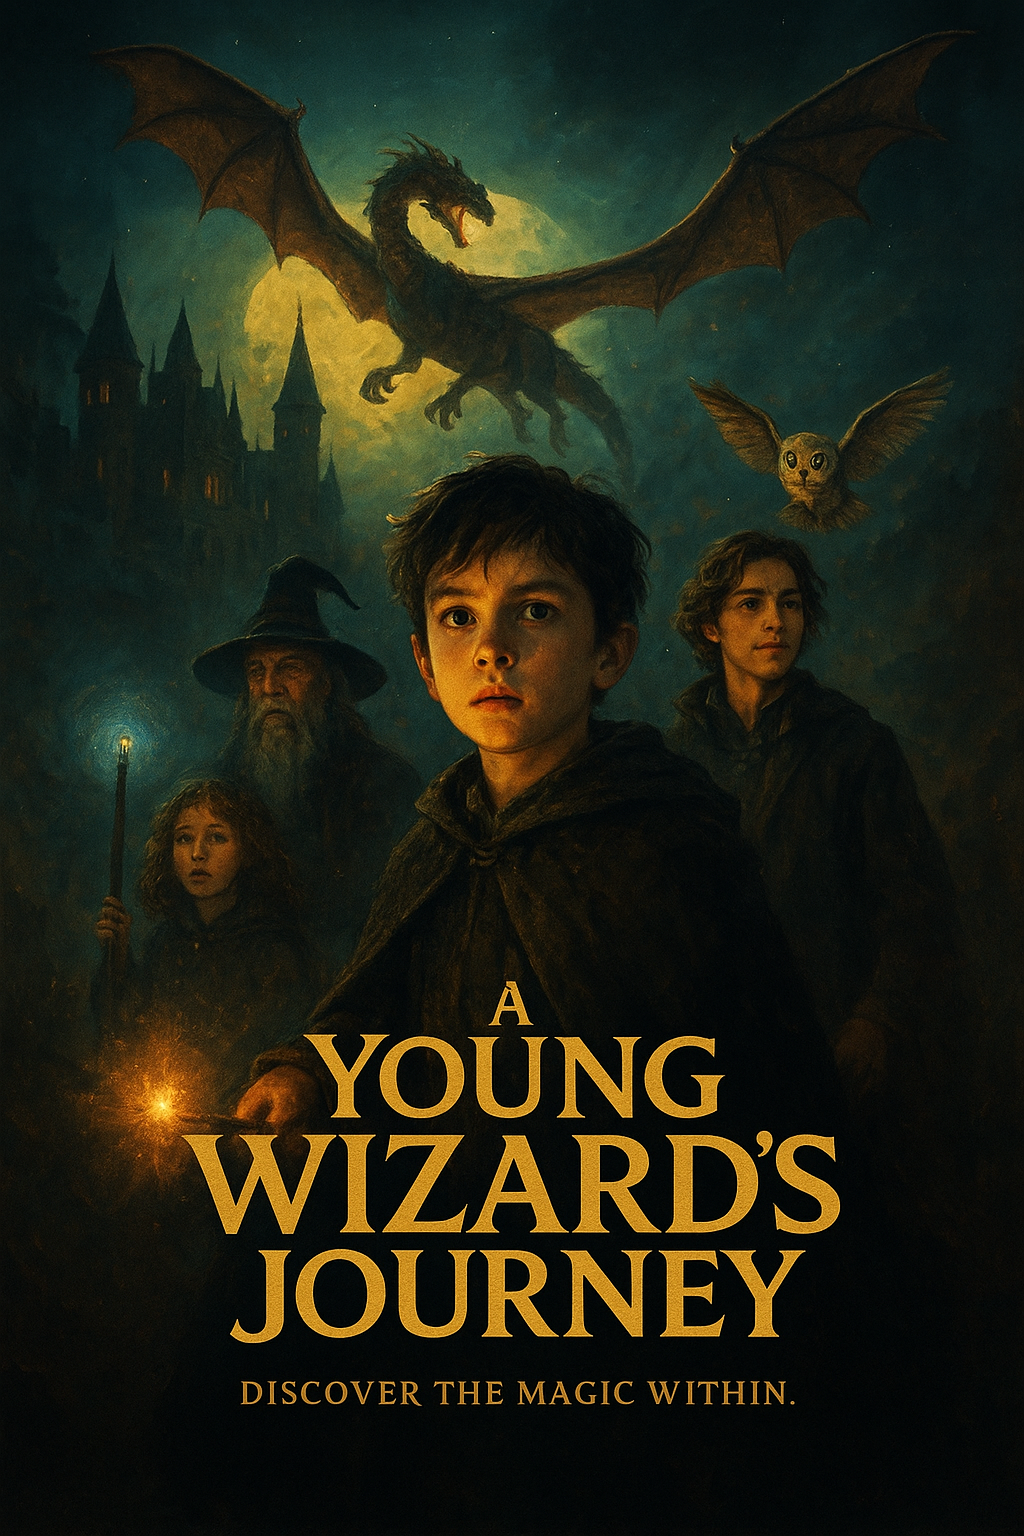

In [71]:
# Task 5c: Display the saved image (5 pts)
from IPython.display import Image, display

# YOUR CODE HERE - display the poster you saved
display(Image(poster_filename))


---

## Task 6: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 6a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 6a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 6b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 6b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 6c: Push your branch (5 pts)

!git push -u origin homework-2

### 6d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/anthonythayes/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [ ]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE
    pass

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
YOUR ORIGINAL MOVIE IDEA HERE - BE CREATIVE!
Describe the plot, characters, setting, visual style, and mood.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application and learned a professional Git workflow!